# Body of the code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

!uv pip install -q --system numba-cuda==0.4.0
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

import numba
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_normal_float32

## Parameters

In [2]:
# Number of trajectories
M = 100

# Total time steps (incl. burn-in)
N = 5_000_000

dt = 2e-3

# Burn-in (removing initial time steps to forget ic)
burn = 500
assert burn < N

## Potential

In [3]:
# Necessarily symmetric
def Vprime(x, a=10.0):
  if x>a: return 3.0*(x-(a+2.0))*(x-a)**2 + (x-a)**3
  elif x<-a: return 3.0*(x+(a+2.0))*(x+a)**2 + (x+a)**3
  else: return 2.0/(5.0*a**2)*x

# Device function (runs on GPU only) - this will inform the CUDA simulations
@cuda.jit(device=True)
def device_Vprime(x, a):
  if x>a: return 3.0*(x-(a+2.0))*(x-a)**2 + (x-a)**3
  elif x<-a: return 3.0*(x+(a+2.0))*(x+a)**2 + (x+a)**3
  else: return 2.0/(5.0*a**2)*x


#@cuda.jit(device=True)
#def device_Vprime(x, a):
#  return x*x*x - 3*x

## RNG

In [4]:
#noises = np.random.normal((M,N))
#device_noises = cuda.device_array
# Copying massive host array to device is bad - consider generating noises in device

host_seed = 2**63 - 1
# This is necessary for the xoroshiro generator

## Simulation Functions

Initiate M parallel processes, each simulating N steps of the Overdamped Langevin equation, from the given $V'(x)$ above.

Check that at no point do we convert to double, or else all this we los a lot of optimisation... In any case the current issue is memory allocation due to the size of the arrays, not speed... Still!

In [5]:
def launch_EMOL_M32(a=10.0, N=25_000, M=200, dt=np.single(1e-3), eps=0.5, blockdim=256, ic=0.0, rngseed=host_seed):
  griddim = int(np.ceil(M/blockdim)) # for some reason np.ceil() returns double?
  host_X = np.empty((M,N), dtype=np.single)
  host_X[:,0] = ic
  dev_X = cuda.to_device(host_X)
  a = np.single(a)

  rng_states = create_xoroshiro128p_states(M, seed=rngseed) # necessary for device rng
  sqrt2epsdt = np.single(np.sqrt(2*eps*dt))

  kernel_update_traj32_devrng[griddim, blockdim](dev_X, a, N, M, dt, sqrt2epsdt, rng_states)
  cuda.synchronize()

  host_X = dev_X.copy_to_host()
  return host_X


@cuda.jit # kernel callcable from host
def kernel_update_traj32_devrng(dev_X, a, N, M, dt, sqrt2epsdt, rng_states):
  # a kernel function that uses xoroshiro pseudo-rng to generate noises matrix
  glob_idx = cuda.grid(1)
  if glob_idx >= M:
    return
  x = dev_X[glob_idx, 0]
  for i in range(N-1):
    noise = xoroshiro128p_normal_float32(rng_states, glob_idx)
    x = kernel_1stepEMOL(x, a, sqrt2epsdt, dt, noise)
    dev_X[glob_idx, i+1] = x


@cuda.jit(device=True) # device function
def kernel_1stepEMOL(x, a, sqrt2epsdt, dt, noise):
  drift = -device_Vprime(x, a) * dt
  diff = sqrt2epsdt * noise
  x += drift + diff
  return x

In [6]:
def traj_acov_WK_unbiased(traj): # host function
  x = traj - np.mean(traj)
  n = len(x)
  npad = 1 << (2*n-1).bit_length() # zero-padding for fft
  # This line is cool but fucking unreadable, consider replacing with:
  #npad = 2 ** (2*n-1).bit_length() # or something similar, like
  #npad = 2 ** np.log(2*n-1)/np.log(2) # this is clearly inefficient lol
  Fx = np.fft.rfft(x, n=npad)
  ps = Fx * np.conjugate(Fx) # power spectrum - see Weiner Khinchin
  acov = np.fft.irfft(ps, n=npad)
  acov = acov[:n]
  count = np.arange(n, 0, -1) # counts for unbiased weighting; n, n-1, ..., 1
  return acov/count

def acovs_WK_unbiased(X): # host function
  acovs = np.empty((np.shape(X)))
  for i in range(np.shape(X)[0]):
    acovs[i] = traj_acov_WK_unbiased(X[i])
  return acovs

## Occupancy Optimisation

In [7]:
print(f"Compute Capability: {cuda.get_current_device().compute_capability}")
print(f"CUDA ver.: {cuda.runtime.get_version()}")

Compute Capability: (7, 5)
CUDA ver.: (12, 5)


## Running Simulations

In [8]:
t = np.arange(N - burn) * dt
X = launch_EMOL_M32(a=2.0, M=M, N=N, dt=dt, blockdim=16)
X_burned = X[:, burn:]

acovs = acovs_WK_unbiased(X_burned)
acovs_mean, acovs_sd = np.mean(acovs, axis=0, dtype=np.float32), np.std(acovs, axis=0, ddof=1, dtype=np.float32)
acf = acovs_mean / acovs_mean[0]
acf_sd = acovs_sd / acovs_mean[0]

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


## Plots

So... autocorrelation functions, eh? For a bistable system, such as one like $V(x) = \frac14x^4-\frac32x^2$, they can be a little funny. Namely, how fast such a system forgets is dominated by 2 different terms; $C(\tau)\approx k_{fast}\ e^{-\tau/\tau_{intra}}+k_{slow}\ e^{-\tau/\tau_{inter}}$

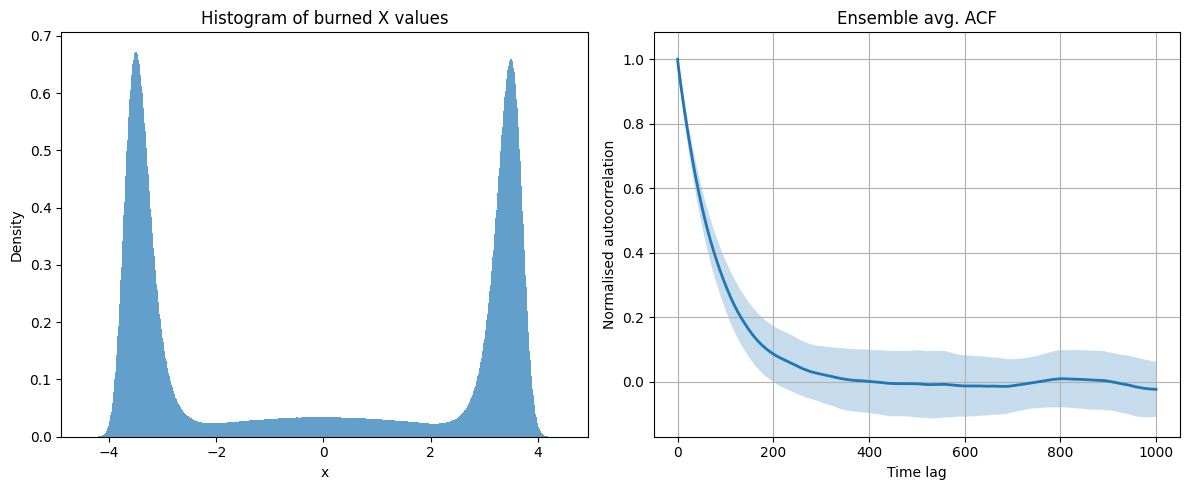

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.hist(X_burned.flatten(), bins=800, density=True, alpha=0.7, align="mid")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Histogram of burned X values")

plt.subplot(1,2,2)
mask = t <= t[len(t)//10] # to prevent noise
#mask = t <= min(1.0, t[-1])
plt.plot(t[mask], acf[mask], label="ACF", lw=2.0)
plt.fill_between(t[mask],
                 acf[mask] + acf_sd[mask],
                 acf[mask] - acf_sd[mask], alpha=0.25)
plt.xlabel("Time lag")
plt.ylabel("Normalised autocorrelation")
plt.title("Ensemble avg. ACF")
#plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

In [10]:
np.any(np.isnan(X_burned)), np.any(np.isinf(X_burned))

(np.False_, np.False_)

# Experiments

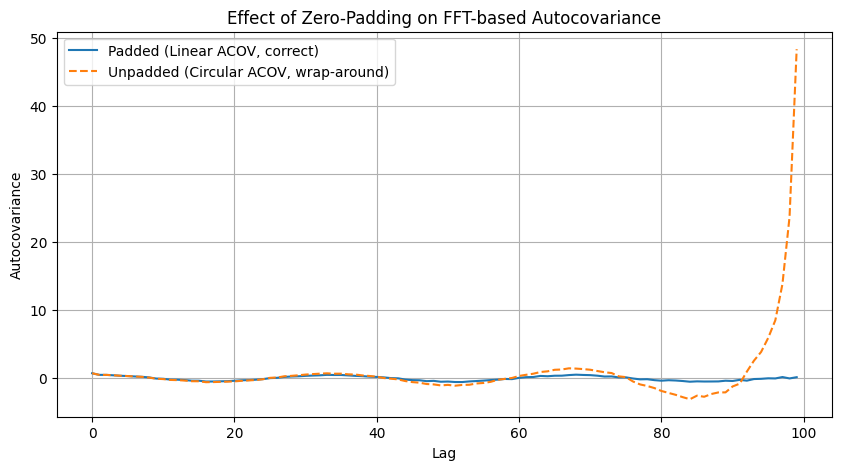

In [11]:
# ChatGPT generated:
# This is meant to help visualise what the "wraparound" effect we get causes
#   when we do not zero-pad our FFT input, though I don't find it too helpful.

import numpy as np
import matplotlib.pyplot as plt

def acov_fft(y, pad=True):
    """Compute autocovariance using FFT, optionally with zero-padding."""
    y = y - np.mean(y)
    n = len(y)
    npad = 1 << (2 * n - 1).bit_length() if pad else n  # pad to next power-of-two ≥ 2n
    Fy = np.fft.rfft(y, n=npad)
    ps = Fy * np.conjugate(Fy)
    acov = np.fft.irfft(ps, n=npad)[:n]
    acov /= np.arange(n, 0, -1)  # unbiased normalization
    return acov

# Generate a simple signal
np.random.seed(0)
x = np.sin(np.linspace(0, 6 * np.pi, 100)) + 0.5 * np.random.randn(100)

# Compute autocovariance with and without zero-padding
acov_padded = acov_fft(x, pad=True)
acov_unpadded = acov_fft(x, pad=False)

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(acov_padded, label="Padded (Linear ACOV, correct)")
plt.plot(acov_unpadded, label="Unpadded (Circular ACOV, wrap-around)", linestyle='--')
plt.title("Effect of Zero-Padding on FFT-based Autocovariance")
plt.xlabel("Lag")
plt.ylabel("Autocovariance")
plt.legend()
plt.grid(True)
plt.show()